In [26]:
import argparse, logging, copy
from types import SimpleNamespace
from contextlib import nullcontext
import os

import torch
from torch import optim
import torch.nn as nn
from torchvision import transforms
import numpy as np
from fastprogress import progress_bar
from ddpm_conditional import Diffusion

import wandb
from utils import *
from modules import UNet_conditional, EMA

In [ ]:
def combine_images(image_list, output_path, images_per_row=10):
    """
    Combine a list of images into a single image with a specified number of images per row.

    Parameters:
    - image_list: List of image objects (Pillow Image objects or equivalent).
    - output_path: Path to save the combined image.
    - images_per_row: Number of images to display in each row (default is 10).
    """
    # Calculate the dimensions of the combined image
    _, image_width, image_height = image_list[0].size()
    combined_width = images_per_row * image_width
    combined_height = ((len(image_list) - 1) // images_per_row + 1) * image_height

    # Create a new image for the combined result
    combined_image = Image.new('RGB', (combined_width, combined_height), (255, 255, 255))

    # Paste each image onto the combined image
    for i, image_tensor in enumerate(image_list):
        to_pil = transforms.ToPILImage()
        image = to_pil(image_tensor)
        x_offset = (i % images_per_row) * image_width
        y_offset = (i // images_per_row) * image_height
        box = (x_offset, y_offset, x_offset + image_width, y_offset + image_height)
        combined_image.paste(image, box)

    # Save the combined image
    combined_image.save(output_path)

In [37]:
config = SimpleNamespace(    
    run_name = "DDPM_conditional",
    remove_deep_conv = True,
    basic_dim = 64,
    epochs = 100,
    noise_steps=100,
    seed = 42,
    batch_size = 10,
    img_size = 32,
    num_classes = 101,
    dataset_path = "C:\Code\cs771_project\data",
    # dataset_path = "/mnt/c/Code/cs771_project/data/",
    # dataset_path = "/storage08/shuchen/DDPM/",
    train_folder = "train",
    val_folder = "test",
    device = "cuda",
    slice_size = 1,
    do_validation = True,
    fp16 = True,
    log_every_epoch = 10,
    num_workers=10,
    lr = 5e-3)

In [6]:
n = 1

# model_path = os.path.join(config.dataset_path, "")
device = config.device
model = UNet_conditional(num_classes=config.num_classes).to(device)
diffusion = Diffusion(img_size=config.img_size, device=device)
# ckpt = torch.load(model_path)
# diffusion.load(model_path)

# y = torch.Tensor([6] * n).long().to(device)
labels = torch.arange(config.num_classes).long().to(device)
sampled_images = diffusion.sample(use_ema=False, labels=labels)


09:09:36 - INFO: Sampling 101 new images....


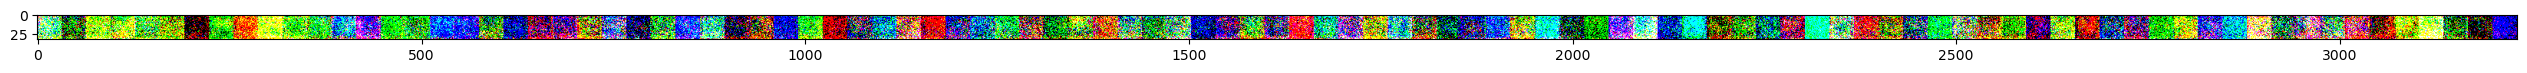

In [8]:
plot_images(sampled_images)


In [13]:
print(sampled_images[0].size())

torch.Size([3, 32, 32])


In [38]:


combine_images(sampled_images, os.path.join(config.dataset_path, 'combined_image.png'), images_per_row=10)